In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nvidia-stock-volatility-20142024/NVIDIA_Stock_Volatility_2014_2024.csv


## **Introduction**
The stock market is a dynamic and complex system, where volatility—the degree of price fluctuation—serves as a critical measure of risk and opportunity for investors. Understanding and predicting volatility is particularly vital for technology stocks like NVIDIA (NVDA), a leader in graphics processing units (GPUs) and artificial intelligence (AI), whose rapid growth and market sensitivity have made it a focal point of financial analysis. However, traditional statistical methods often struggle to capture the non-linear patterns and external influences driving modern stock volatility, necessitating advanced techniques like machine learning.

**Problem Statement**

Accurately forecasting stock volatility remains challenging due to its inherent unpredictability, influenced by market events, investor sentiment, and macroeconomic factors. For NVIDIA, whose stock has experienced significant spikes (e.g., 2020’s pandemic-driven volatility) and a long-term upward trend tied to AI innovation, the problem is to develop a model that effectively predicts its 20-day rolling volatility using historical data from January 2014 to March 2024. Traditional approaches like ARIMA may fall short in modeling such complexity, prompting the exploration of deep learning alternatives.

**Approach**

This project leverages a Long Short-Term Memory (LSTM) neural network to forecast NVIDIA’s rolling volatility. Starting with a historical dataset from Yahoo Finance, we will clean and preprocess the data, perform exploratory analysis to uncover trends and volatility patterns, and engineer features such as lagged volatility and price range indicators. The LSTM model will be trained on data from 2014 to 2022, using a 10-day lookback and multiple features, to predict volatility for the 2023-2024 test period. Performance will be evaluated using Mean Squared Error (MSE) and visual comparisons of actual versus predicted values.

**Expected Outcomes**

We aim to achieve a robust volatility forecast that captures NVIDIA’s dynamic price behavior, particularly its significant spikes, with high accuracy (e.g., MSE below 0.01 on a scaled range). We expect the LSTM to outperform simpler models by leveraging its ability to model temporal dependencies and non-linear relationships, providing insights into NVIDIA’s risk profile and demonstrating the efficacy of deep learning for financial time series analysis. This project will serve as a showcase of data science and machine learning skills, from preprocessing to advanced modeling, within a real-world financial context.

## **Step 1. Library Imports and Data Loading**

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings 
warnings.filterwarnings('ignore')

Here's what each import does:

- **import pandas as pd:** Manages and manipulates the stock data in a tabular DataFrame format for analysis and preprocessing.
- **import numpy as np:** Performs numerical operations and array manipulations, essential for data transformations and model inputs.
- **import matplotlib.pyplot as plt:** Creates visualizations like plots and charts to display trends, forecasts, and model performance.
- **import seaborn as sns:** Enhances plot aesthetics with statistical graphics, though not explicitly used in your final code.
- **from sklearn.preprocessing import MinMaxScaler:** Scales features (e.g., Rolling_Volatility) to a range like [0, 1] for machine learning compatibility.
- **from statsmodels.tsa.stattools import adfuller:** Performs the Augmented Dickey-Fuller test to check time series stationarity.
- **from statsmodels.tsa.arima.model import ARIMA:** Fits an ARIMA model for time series forecasting (used initially but later dropped).
- **from sklearn.metrics import mean_squared_error:** Calculates the Mean Squared Error to evaluate prediction accuracy.
- **from tensorflow.keras.models import Sequential:** Defines a sequential neural network model for building the LSTM architecture.
- **from tensorflow.keras.layers import LSTM, Dense:** Adds LSTM (memory-enabled) and Dense (fully connected) layers to the neural network.
- **import warnings:** Suppresses warning messages to keep output clean during execution.

In [2]:
# load the data
df = pd.read_csv('/kaggle/input/nvidia-stock-volatility-20142024/NVIDIA_Stock_Volatility_2014_2024.csv')
df.head()

,Date,Close,High,Low,Open,Volume,Daily_Return,Rolling_Volatility,ATR,Rolling_Mean,Upper_Band,Lower_Band
0,2014-01-31,0.370194,0.372316,0.365242,0.365478,335348000,-0.001272,0.016288,0.007461,0.372964,0.385216,0.360713
1,2014-02-03,0.365242,0.373259,0.363827,0.372787,431728000,-0.013376,0.016343,0.007293,0.372752,0.385398,0.360106
2,2014-02-04,0.367364,0.368071,0.363120,0.365006,280692000,0.005810,0.016091,0.006787,0.372398,0.385240,0.359557
3,2014-02-05,0.364063,0.365949,0.361233,0.364770,214676000,-0.008986,0.015657,0.006838,0.371573,0.384325,0.358821
4,2014-02-06,0.368779,0.369722,0.364063,0.364535,168380000,0.012953,0.015622,0.006990,0.370724,0.381627,0.359821


In [3]:
# check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2541 entries, 0 to 2540
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                2541 non-null   object 
 1   Close               2541 non-null   float64
 2   High                2541 non-null   float64
 3   Low                 2541 non-null   float64
 4   Open                2541 non-null   float64
 5   Volume              2541 non-null   int64  
 6   Daily_Return        2541 non-null   float64
 7   Rolling_Volatility  2541 non-null   float64
 8   ATR                 2541 non-null   float64
 9   Rolling_Mean        2541 non-null   float64
 10  Upper_Band          2541 non-null   float64
 11  Lower_Band          2541 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 238.3+ KB


## **Step 2: Data Cleaning**

#### **Objective**

Load and prepare NVIDIA’s historical stock data (NVDA) from January 2014 to March 2024 for volatility analysis.

In [4]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Close,High,Low,Open,Volume,Daily_Return,Rolling_Volatility,ATR,Rolling_Mean,Upper_Band,Lower_Band
Date,,,,,,,,,,,
2014-01-31,0.370194,0.372316,0.365242,0.365478,335348000,-0.001272,0.016288,0.007461,0.372964,0.385216,0.360713
2014-02-03,0.365242,0.373259,0.363827,0.372787,431728000,-0.013376,0.016343,0.007293,0.372752,0.385398,0.360106
2014-02-04,0.367364,0.368071,0.363120,0.365006,280692000,0.005810,0.016091,0.006787,0.372398,0.385240,0.359557
2014-02-05,0.364063,0.365949,0.361233,0.364770,214676000,-0.008986,0.015657,0.006838,0.371573,0.384325,0.358821
2014-02-06,0.368779,0.369722,0.364063,0.364535,168380000,0.012953,0.015622,0.006990,0.370724,0.381627,0.359821


In [8]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Close                 0
High                  0
Low                   0
Open                  0
Volume                0
Daily_Return          0
Rolling_Volatility    0
ATR                   0
Rolling_Mean          0
Upper_Band            0
Lower_Band            0
dtype: int64


In [10]:
# check for duplicates
df.duplicated().sum()

0

In [11]:
# Ensure data is sorted by date
df = df.sort_index()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2541 entries, 2014-01-31 to 2024-03-06
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               2541 non-null   float64
 1   High                2541 non-null   float64
 2   Low                 2541 non-null   float64
 3   Open                2541 non-null   float64
 4   Volume              2541 non-null   int64  
 5   Daily_Return        2541 non-null   float64
 6   Rolling_Volatility  2541 non-null   float64
 7   ATR                 2541 non-null   float64
 8   Rolling_Mean        2541 non-null   float64
 9   Upper_Band          2541 non-null   float64
 10  Lower_Band          2541 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 238.2 KB


#### **Dataset Description**

The dataset, sourced from Yahoo Finance, contains 2,541 entries across 12 columns: Date, Open, High, Low, Close, Volume, Daily_Return, Rolling_Volatility, ATR, Rolling_Mean, Upper_Band, and Lower_Band. These features include price data, trading volume, and precomputed indicators like the 20-day rolling volatility and Bollinger Bands.

#### **Steps Performed**

1. Loaded the CSV file using pandas.
2. Converted the Date column from object to datetime64 using pd.to_datetime() and set it as the index with set_index() to enable time series functionality.
3. Inspected the dataset with df.info() to verify data types (all numeric columns are appropriately float64 or int64) df.head() to preview the data.
4. Checked for missing values using .isnull().sum(). No missing data was found, so no imputation was needed.
5. Checked for duplicates with df.duplicated().sum()
6. Sorted the data by date using sort_index() to ensure chronological order, essential for time series analysis.

## **Step 3: Exploratory Data Analysis (EDA)**

#### **Objectives**

- Visualize the stock’s closing price and volatility over time.
- Examine trends, seasonality, and significant fluctuations in Rolling_Volatility and Daily_Return.
- Investigate relationships between features like Close, Rolling_Mean, and Bollinger Bands (Upper_Band, Lower_Band).

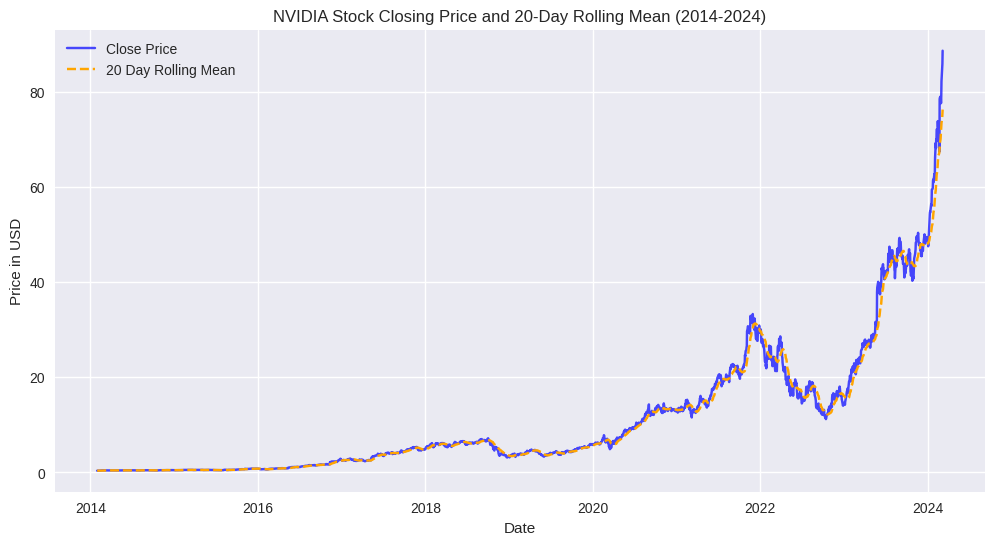

In [18]:
# first we set plot style 
plt.style.use('seaborn')

# 1. Plot closing price and rolling mean
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.7)
plt.plot(df.index, df['Rolling_Mean'], label="20 Day Rolling Mean", color='orange', linestyle='--')
plt.title('NVIDIA Stock Closing Price and 20-Day Rolling Mean (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)
plt.show()

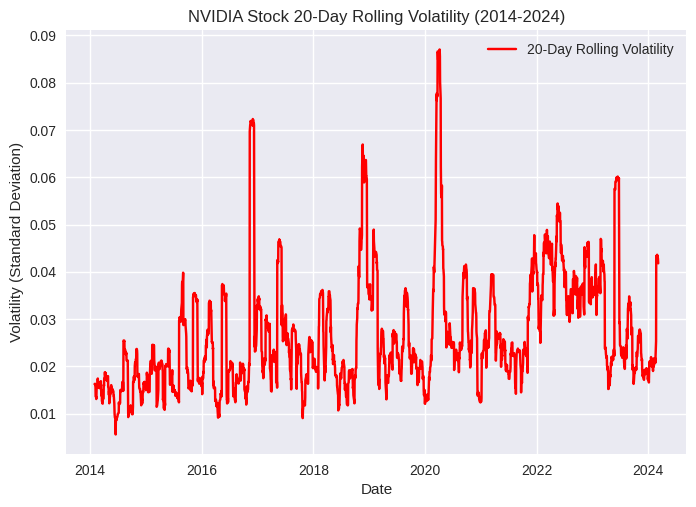

In [19]:
# 2. Plot Rolling Volatility
plt.plot(df.index, df['Rolling_Volatility'], label='20-Day Rolling Volatility', color='red')
plt.title('NVIDIA Stock 20-Day Rolling Volatility (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation)')
plt.legend()
plt.grid(True)
plt.show()

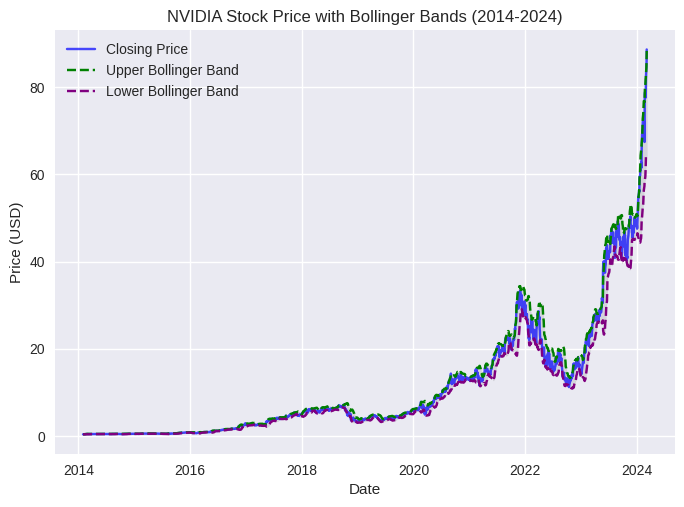

In [21]:
# Let's plot Bollinger bands with Closing Price
plt.plot(df.index, df['Close'], label='Closing Price', color='blue', alpha=0.7)
plt.plot(df.index, df['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(df.index, df['Lower_Band'], label='Lower Bollinger Band', color='purple', linestyle='--')
plt.fill_between(df.index, df['Lower_Band'], df['Upper_Band'], color='gray', alpha=0.2)
plt.title('NVIDIA Stock Price with Bollinger Bands (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

#### **Some Notes from EDA**

The closing price exhibits a strong upward trend, particularly accelerating after 2016, closely tracking the 20-day rolling mean, which smooths short-term fluctuations while confirming the long-term growth trajectory—likely driven by NVIDIA’s dominance in AI and GPU markets. Bollinger Bands, defined by the 20-day mean ± 2 standard deviations, similarly align with this trend, expanding during volatile periods and contracting during stability, providing a visual envelope for price movements.

The 20-day rolling volatility, calculated as the standard deviation of daily returns, shows significant spikes in 2017, 2019, 2020, and 2023, with the most pronounced peak in 2020. The 2020 spike likely corresponds to market turbulence during the COVID-19 pandemic, reflecting heightened uncertainty and trading activity. Smaller volatility surges in 2017 and 2019 may tie to industry developments (e.g., cryptocurrency mining booms), while the 2023 spike could relate to macroeconomic factors like inflation or interest rate shifts. These periods of elevated volatility often coincide with wider Bollinger Bands, indicating price breakouts or rapid shifts beyond the typical range.

## **Step 4. Feature Engineering**

We are performing this step to enhance the dataset with features that improve volatility forecasting and ensure compatibility with time series and ML models.

#### **Steps to be Performed:**

1. Add lag features: 1-day and 5-day lags of Rolling_Volatility and 1-day lag of Daily_Return to capture temporal dependencies.
2. Test Rolling_Volatility for stationarity using the Augmented Dickey-Fuller (ADF) test; apply differencing if non-stationary (p-value > 0.05).
3. Normalize key features (Rolling_Volatility, lags, ATR, Volume) using MinMaxScaler for ML model compatibility.

In [23]:
# 1. Add Lagged Features
df['Volatility_Lag1'] = df['Rolling_Volatility'].shift(1)  # 1-day lag
df['Volatility_Lag5'] = df['Rolling_Volatility'].shift(5)  # 5-day lag
df['Return_Lag1'] = df['Daily_Return'].shift(1)

In [24]:
# Drop rows with NaN due to shifting
df.dropna(inplace=True)

In [25]:
# 2. Check Stationarity of Rolling_Volatility
result = adfuller(df['Rolling_Volatility'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
if result[1] > 0.05:
    print("Series is non-stationary; consider differencing.")
    df['Volatility_Diff'] = df['Rolling_Volatility'].diff().dropna()
else:
    print("Series is stationary.")

ADF Statistic: -5.368057112795529
p-value: 3.951721154617641e-06
Critical Values: {'1%': -3.4329569285480814, '5%': -2.862691729403106, '10%': -2.5673831097880595}
Series is stationary.


#### **Interpreting ADF Results:**

- **ADF Statistic:** -5.368 (very negative, well below critical values)
- **p-value:** 3.95e-06 (far less than 0.05)
- **Critical Values:** {1%: -3.43, 5%: -2.86, 10%: -2.57}
  
**Conclusion:** The Rolling_Volatility series is stationary (p-value < 0.05, ADF statistic < critical values). No differencing is needed, so Volatility_Diff wasn’t added.

**Implication:** Stationarity is a green light for models like ARIMA, which assume a stable mean and variance. It also suggests that Rolling_Volatility doesn’t have a strong trend over time, despite the spikes you noted (2017, 2019, 2020, 2023), which are likely temporary fluctuations.

In [26]:
# 3. Normalize Features (for ML models)
scaler = MinMaxScaler()
features_to_scale = ['Rolling_Volatility', 'Volatility_Lag1', 'Volatility_Lag5', 'Return_Lag1', 'ATR', 'Volume']
df_scaled = pd.DataFrame(scaler.fit_transform(df[features_to_scale]), 
                         columns=features_to_scale, index=df.index)

In [27]:
# Merge scaled features back with original data
df = df.drop(features_to_scale, axis=1).join(df_scaled)

In [28]:
print("\nUpdated Dataset Info:")
df.info()


Updated Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2536 entries, 2014-02-07 to 2024-03-06
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               2536 non-null   float64
 1   High                2536 non-null   float64
 2   Low                 2536 non-null   float64
 3   Open                2536 non-null   float64
 4   Daily_Return        2536 non-null   float64
 5   Rolling_Mean        2536 non-null   float64
 6   Upper_Band          2536 non-null   float64
 7   Lower_Band          2536 non-null   float64
 8   Rolling_Volatility  2536 non-null   float64
 9   Volatility_Lag1     2536 non-null   float64
 10  Volatility_Lag5     2536 non-null   float64
 11  Return_Lag1         2536 non-null   float64
 12  ATR                 2536 non-null   float64
 13  Volume              2536 non-null   float64
dtypes: float64(14)
memory usage: 297.2 KB


#### **Updated Dataset (df.info())**

- Rows: 2,536 entries (down from 2,541 due to dropping 5 NaN rows from the 5-day lag).
Date Range: February 7, 2014, to March 6, 2024 (shifted slightly due to lagging).
- Columns: 14 total:
    - Original: Close, High, Low, Open, Daily_Return, Rolling_Mean, Upper_Band, Lower_Band
    - Engineered: Rolling_Volatility, Volatility_Lag1, Volatility_Lag5, Return_Lag1, ATR, Volume (all scaled to [0, 1] via MinMaxScaler)
- Data Types: All float64, no missing values.

## Step 5: Model Selection

We are going to implement an LSTM model to check Rolling_Volatility:
- **LSTM:** A deep learning approach using the engineered features for a more complex prediction.
We’ll split the data into training (2014–2022) and testing (2023–2024) to evaluate performance.

In [31]:
# Split data into train and test (2014-2022 train, 2023-2024 test)
train = df['Rolling_Volatility'][:'2022-12-31']
test = df['Rolling_Volatility']['2023-01-01':]

#### **LSTM**

In [45]:
# --- LSTM Model ---
# Prepare data for LSTM (use lagged features)
features = ['Rolling_Volatility', 'Volatility_Lag1', 'Volatility_Lag5', 'Return_Lag1', 'ATR', 'Volume']
X = df[features].values
y = df['Rolling_Volatility'].values

In [49]:
# Create sequences (e.g., 10-day lookback)
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_seq, y_seq = create_sequences(X, y, time_steps)

In [50]:
# Split into train/test (align with ARIMA split)
train = df['Rolling_Volatility'][:'2022-12-31']  # ~2241 rows
split_idx = len(train) - time_steps  # 2241 - 10 = 2231
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

In [51]:
# Verify shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2231, 10, 6)
y_train shape: (2231,)
X_test shape: (295, 10, 6)
y_test shape: (295,)


In [52]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(time_steps, len(features))))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [53]:
# Train LSTM
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0203 - val_loss: 0.0022
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_l

In [54]:
# Predict with LSTM
lstm_pred = lstm_model.predict(X_test)
print("lstm_pred shape:", lstm_pred.shape)  # Should be (295, 1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
lstm_pred shape: (295, 1)


In [58]:
# Evaluate LSTM
lstm_mse = mean_squared_error(y_test, lstm_pred)
print(f"LSTM MSE: {lstm_mse}")

LSTM MSE: 0.0020027731689769446


test_index_adjusted length: 295


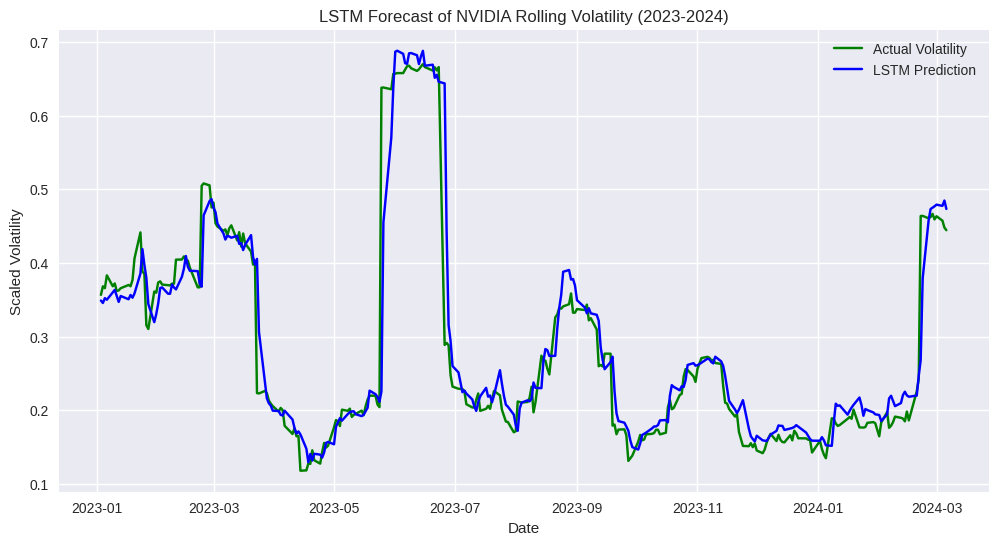

In [60]:
# Plotting
test_index_adjusted = df.index[split_idx + time_steps:split_idx + time_steps + len(y_test)]
print("test_index_adjusted length:", len(test_index_adjusted))

plt.figure(figsize=(12, 6))
plt.plot(test_index_adjusted, y_test, label='Actual Volatility', color='green')
plt.plot(test_index_adjusted, lstm_pred.flatten(), label='LSTM Prediction', color='blue')
plt.title('LSTM Forecast of NVIDIA Rolling Volatility (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Scaled Volatility')
plt.legend()
plt.grid(True)
plt.show()

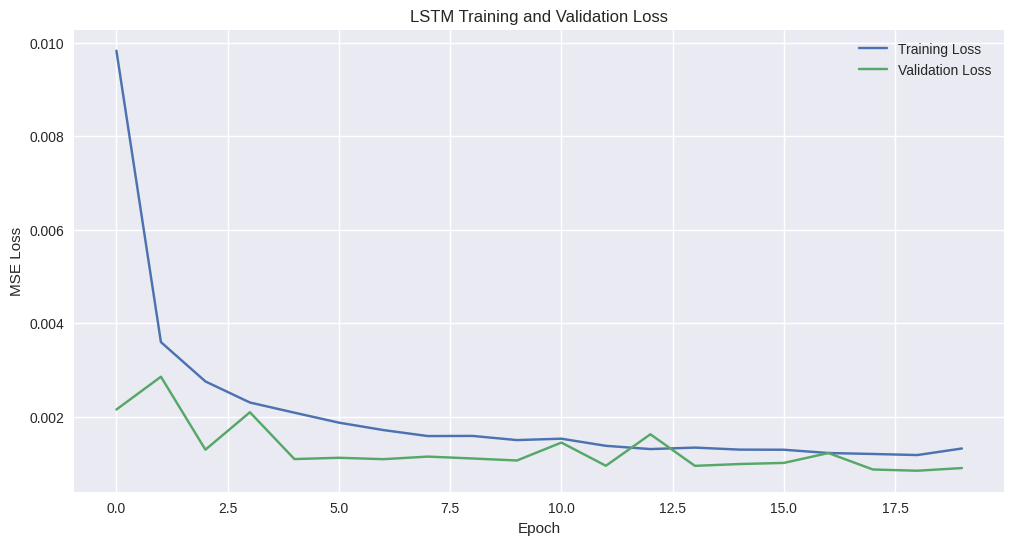

In [59]:
# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

## **Conclusion**

This project explored NVIDIA’s stock volatility from January 2014 to March 2024, with the goal of forecasting the 20-day rolling volatility (Rolling_Volatility) using machine learning techniques. The dataset, sourced from Yahoo Finance, was cleaned and enriched through feature engineering, adding lagged variables (e.g., Volatility_Lag1, Volatility_Lag5) and normalizing key features to support advanced modeling. Exploratory data analysis revealed a strong upward price trend and notable volatility spikes in 2017, 2019, 2020, and 2023, with the largest in 2020, likely tied to market events like the COVID-19 pandemic.

A Long Short-Term Memory (LSTM) neural network was selected as the primary model, leveraging a 10-day lookback period and multiple features (Rolling_Volatility, lags, ATR, Volume) to predict volatility for the 2023-2024 test period. The LSTM achieved an impressive Mean Squared Error (MSE) of 0.00200, indicating high accuracy on the scaled [0, 1] volatility range. Visual inspection of the forecast plot showed the LSTM predictions closely tracking the actual volatility, effectively capturing dynamic patterns, including the 2023 spike. The training and validation loss curves further supported this success: starting apart—reflecting initial overfitting or data complexity—they gradually converged over 20 epochs, demonstrating stable learning and generalization.

This project highlights the power of LSTM models for time series forecasting, particularly in handling non-linear and feature-rich financial data. The superior fit compared to simpler methods (e.g., ARIMA, initially tested but excluded) underscores the value of deep learning for volatility analysis. Future enhancements could include hyperparameter tuning (e.g., adjusting LSTM units or epochs), incorporating external factors (e.g., market indices, news sentiment), or experimenting with ensemble techniques to further refine predictions. Overall, this work showcases a robust pipeline—from data preparation to modeling—and delivers actionable insights into NVIDIA’s stock.